Torch is already installed in Colab - but you can run for fun to check

In [ ]:
#!pip3 install torch

Add the DLH folder in the top-level of your Google Drive
Mount Colab to this location (only run once)

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir("drive/My Drive/DLH_Project")

Mounted at /content/drive


In [2]:
%pwd

'/content/drive/.shortcut-targets-by-id/1vmmLQvXIsZR9fm3bw0w0w0S4STu7QfhY/DLH_Project'

Check that we are in the DLH_Project folder

Load the necessary modules


In [3]:
import pandas as pd
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage import io, transform
import numpy as np

In [4]:
torch.__version__

'1.8.1+cu101'

In [5]:
IMG_PATH =  '/content/drive/MyDrive/DLH_Project/images/'
TRAIN_CSV = '/content/drive/MyDrive/DLH_Project/images/PneumoniaTrain.csv'  #input your train.csv file here
VALID_CSV = '/content/drive/MyDrive/DLH_Project/images/PneumoniaTest.csv'   #input your valid.csv file here

In [6]:
#check train file
df_train = pd.read_csv(TRAIN_CSV, header='infer')
print(df_train.shape)
df_train.head(n=5)

(1145, 19)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00012/study3/...,Female,61,Frontal,PA,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0,NaN,0.0,1.0,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00050/study1/...,Male,62,Frontal,PA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1.0
2,CheXpert-v1.0-small/train/patient00053/study1/...,Male,86,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,NaN,NaN,NaN,NaN,1.0
3,CheXpert-v1.0-small/train/patient00085/study1/...,Male,88,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,1,-1.0,NaN,NaN,NaN,NaN,NaN
4,CheXpert-v1.0-small/train/patient00086/study1/...,Female,77,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_train.iloc[:,12].sum()  #number of positive labels

789

In [8]:
#check test file
df_test = pd.read_csv(VALID_CSV, header=None)
print(df_test.shape)
df_test.head(n=5)

(122, 19)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,CheXpert-v1.0-small/train/patient09010/study1/...,Female,76,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1,1.0,0.0,1.0,NaN,1.0,1.0
1,CheXpert-v1.0-small/train/patient09010/study1/...,Female,76,Frontal,LL,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1,1.0,0.0,1.0,NaN,1.0,1.0
2,CheXpert-v1.0-small/train/patient09012/study1/...,Male,76,Frontal,PA,NaN,NaN,NaN,1.0,1.0,NaN,-1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,CheXpert-v1.0-small/train/patient09015/study4/...,Female,51,Frontal,PA,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,CheXpert-v1.0-small/train/patient09030/study3/...,Male,85,Frontal,AP,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_test.iloc[:,12].sum()  #number of positive labels

78

Create custom dataset for loading images from the filepaths specified in the CSV

In [10]:
from torch.utils.data import Dataset 

class PneumoniaDataset(Dataset): 
  def __init__(self, csv_file, root_dir, transform = None): 
    if csv_file == TRAIN_CSV:
      header = 'infer'
    else:
      header = None  
    df = pd.read_csv(csv_file, header=header)
    #df = self.filterDF(df, n=None)
    self.data_file = df
    self.root_dir = root_dir  #not being used since full path is given
    self.transform = transform

  def filterDF(self, df, n):            
    #df = df.iloc[0:n,:]                  #input n records
    df.fillna(0, inplace=True)            #change all nan to 0
    df =df[df.iloc[:,12] >= 0]            #only take the 0s and 1s in Pneumonia column
    df = df[df.iloc[:, 3] == 'Frontal']   #filter views: Frontal or Lateral
    for i in range(5,19):                 #5,19 denotes labels 1-14
      for j in range(len(df)):            #convert all -1s to 0s
        if df.iloc[j,i] < 0:
          df.iloc[j,i] = 0

    print('n samples = ', len(df))  
    print('number of positives ', df.columns[12], ' ', df[df.columns[12]].sum())

    return df

    
  def __len__(self):
    return(len(self.data_file))

  def __getitem__(self, idx): 
    path = self.data_file
    #img_path = os.path.join(self.root_dir, self.data_file.iloc[idx, 0])
    img_path = IMG_PATH + self.data_file.iloc[idx, 0]
    #print(img_path)
    image = io.imread(img_path)
    if self.transform:
      image = self.transform(image)
    y = self.data_file.iloc[idx, 12]  #important !!! column 12 is pneumonia
    y = np.array(y, dtype='float')
    y = torch.tensor(y, dtype = torch.float32)  #dont forget to change y to tensor; long is required for loss calculation see https://jdhao.github.io/2017/11/15/pytorch-datatype-note/
    return image, y

In [ ]:
'''
dataset = PneumoniaDataset(csv_file=TRAIN_CSV, root_dir="images/", transform=transforms.ToTensor())  #root_dir not being used since full path is given in TRAIN_CSV
# using the ToTensor transform to grab image shape easily

print(len(dataset))
for i in range(1):
  print(i, dataset[i])
  print(i, "image shape: ", dataset[i][0].size())
'''

'\ndataset = PneumoniaDataset(csv_file=TRAIN_CSV, root_dir="images/", transform=transforms.ToTensor())  #root_dir not being used since full path is given in TRAIN_CSV\n# using the ToTensor transform to grab image shape easily\n\nprint(len(dataset))\nfor i in range(1):\n  print(i, dataset[i])\n  print(i, "image shape: ", dataset[i][0].size())\n'

Dataloader


In [11]:
def load_data(csv_filepath, root_dir):
  img_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomResizedCrop(224)
  ])
  train_data = PneumoniaDataset(csv_filepath, root_dir, transform = img_transform) 
  train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True) 
  return train_loader

In [12]:
train_loader = load_data(TRAIN_CSV, root_dir="images/")  #root_dir not being used since full path is given in TRAIN_CSV
valid_loader = load_data(VALID_CSV, root_dir="images/")  #root_dir not being used since full path is given in VALID_CSV

In [13]:
#sanity checks
data = iter(train_loader)
data_batch1 = next(data)
print(data_batch1[0].shape)  #shape looks right
print(data_batch1[0][0])  #data of 1st sample (1,224,224)

torch.Size([32, 1, 224, 224])
tensor([[[0.4861, 0.5047, 0.4789,  ..., 0.7609, 0.4567, 0.4709],
         [0.3410, 0.3452, 0.3650,  ..., 0.4915, 0.4848, 0.4893],
         [0.2853, 0.2875, 0.2863,  ..., 0.4964, 0.5065, 0.4868],
         ...,
         [0.4527, 0.4606, 0.5057,  ..., 0.0224, 0.0242, 0.0249],
         [0.4634, 0.4596, 0.5031,  ..., 0.0266, 0.0266, 0.0266],
         [0.4623, 0.4790, 0.4927,  ..., 0.0275, 0.0275, 0.0275]]])


In [14]:
#sanity checks
data = iter(valid_loader)
data_batch1 = next(data)
print(data_batch1[0].shape)  #shape looks right
print(data_batch1[0][0])  #data of 1st sample (1,224,224)

torch.Size([32, 1, 224, 224])
tensor([[[0.1102, 0.1481, 0.1432,  ..., 0.1299, 0.1293, 0.1164],
         [0.1608, 0.1714, 0.2094,  ..., 0.1664, 0.1534, 0.1088],
         [0.1922, 0.1842, 0.2630,  ..., 0.1955, 0.1758, 0.1178],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.9282, 0.9091, 0.8979],
         [0.0000, 0.0000, 0.0000,  ..., 0.9426, 0.9207, 0.8956],
         [0.0000, 0.0000, 0.0000,  ..., 0.8680, 0.9205, 0.8908]]])


Example images


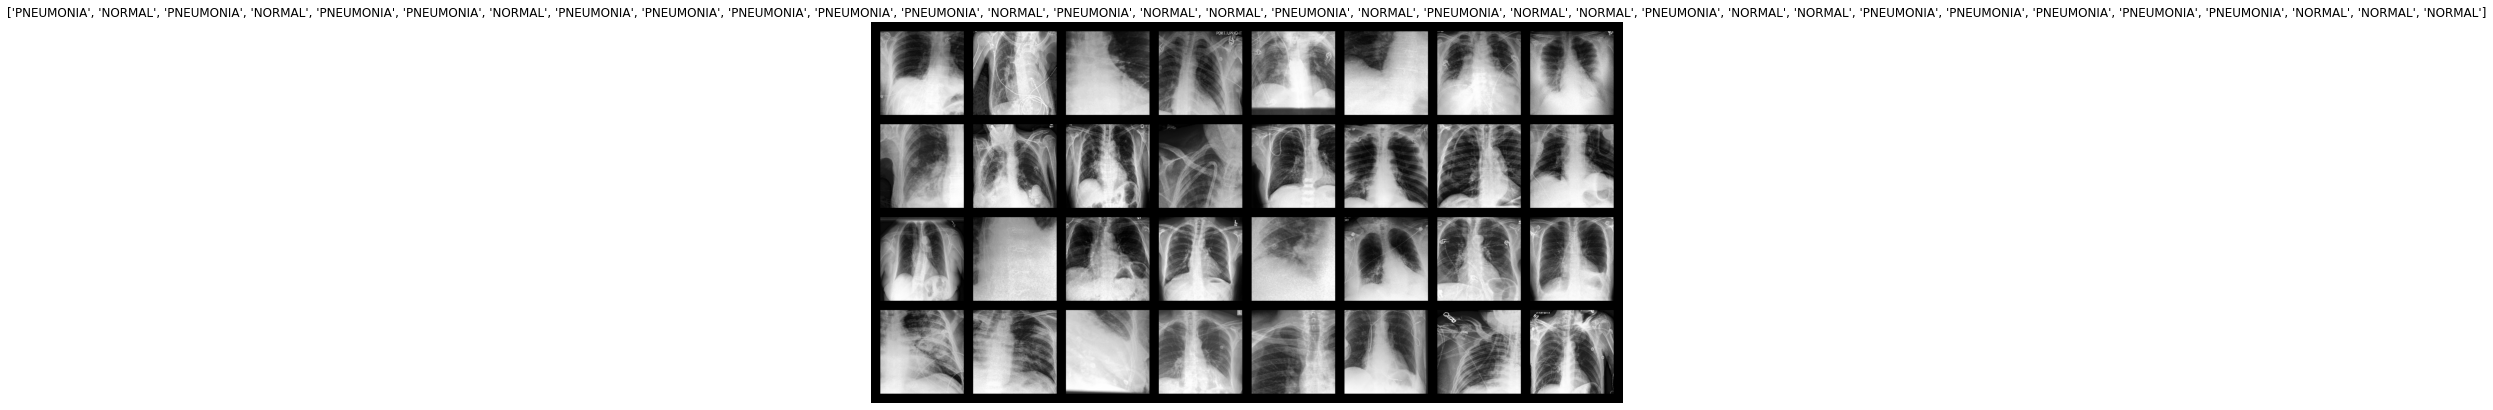

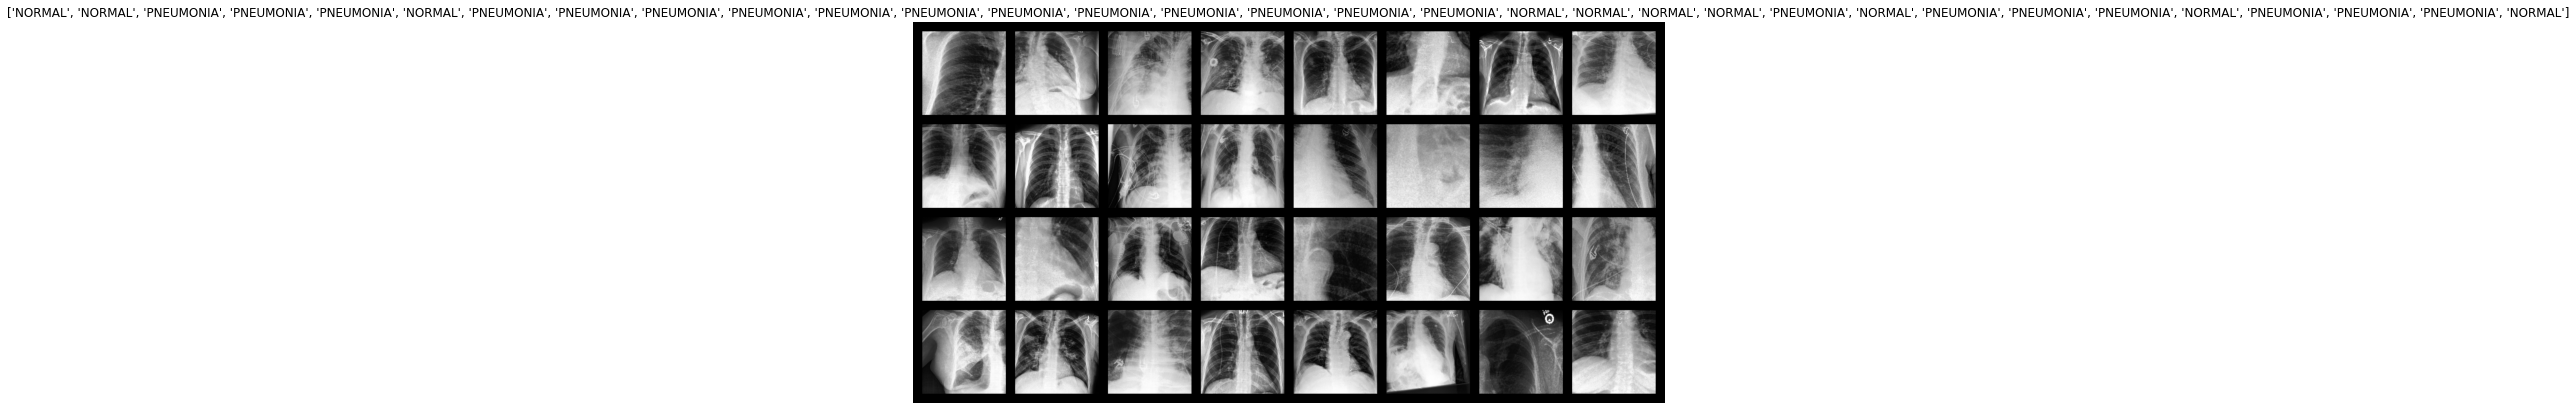

In [15]:
import numpy as np

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images, padding=25)
    imshow(img, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])

train_loader = load_data(TRAIN_CSV, root_dir="images/")  #root_dir not being used since full path is given in TRAIN_CSV

for i in range(2):
    show_batch_images(train_loader)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.w = 224  #width and height of image
        self.conv1 = nn.Conv2d(1, 16, 5, 2)  #(input=1, output, kernel size, stride)
        self.pool = nn.MaxPool2d(3,1)  #(kernel size, stride)
        self.norm2d_1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.norm2d_2 = nn.BatchNorm2d(32)  
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.norm2d_3 = nn.BatchNorm2d(64)  
        self.fc1 = nn.Linear(64 * 96 * 96 , 120)  #need to calculate the flattened matrix = channels * width * height
        self.norm1d_1 = nn.BatchNorm1d(120)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 60)
        self.norm1d_2 = nn.BatchNorm1d(60)
        self.fc3 = nn.Linear(60, 1)  #change output to one for binary classification
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #input is of shape (batch_size=32, 1, 224, 224) if you did the dataloader right
        
        x = F.leaky_relu(self.conv1(x))
        x = self.norm2d_1(x)
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.norm2d_2(x)
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.norm2d_3(x)
        x = self.pool(x)
        x = x.view(-1, 64*96*96)  #flatten and pass to nn.Linear
        x = F.leaky_relu(self.fc1(x))
        x = self.norm1d_1(x)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.norm1d_2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x  



In [17]:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (norm2d_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (norm2d_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (norm2d_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=589824, out_features=120, bias=True)
  (norm1d_1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (norm1d_2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()


In [18]:
#define optimizer and loss function
import torch.optim as optim
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [19]:

def train_model(model, train_loader, valid_loader, n_epoch, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim

    model.train() # prep model for training
    
    
    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for data, target in train_loader:
            
            optimizer.zero_grad()
            y_hat = model(data)  #forward pass
            y_hat = torch.squeeze(y_hat, dim=1)
                       
            #print('target dtype = ',target.type())
            #print('yhat dtype = ',y_hat.type())
            loss = criterion(y_hat, target)  #loss calculation          
            
            """ backward pass """
            loss.backward()
            """ optimization """
            optimizer.step()   
            
            curr_epoch_loss.append(loss.cpu().data.numpy()) 
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        evaluate(model, valid_loader)
    return model


In [20]:
from sklearn.metrics import *

#input: Y_pred,Y_true
#output: accuracy, auc, precision, recall, f1-score
def classification_metrics(Y_pred, Y_true):

    Y_pred_prob = Y_pred
    Y_pred_label = Y_pred > 0.5  #boolean dtype
    Y_true = Y_true > 0          #boolean dtype
    #print(Y_pred_prob)
    #print(Y_pred_label)
    #print(Y_true)
    acc, auc, precision, recall, f1score = accuracy_score(Y_true, Y_pred_label), \
                                           roc_auc_score(Y_true, Y_pred), \
                                           precision_score(Y_true, Y_pred_label), \
                                           recall_score(Y_true, Y_pred_label), \
                                           f1_score(Y_true, Y_pred_label)
    return acc, auc, precision, recall, f1score


#input: model, loader
def evaluate(model, valid_loader):
    model.eval()
    all_y_true = torch.FloatTensor()  #this will accumulate all batches
    all_y_hat = torch.FloatTensor()   #this will accumulate all batches
    
    for x, y_val in valid_loader:
        y_hat = model(x)
        # convert shape from [batch size, 1] to [batch size]
        y_hat = y_hat.view(y_hat.shape[0])

        all_y_hat = torch.cat((all_y_hat, y_hat.to('cpu').float()), dim=0)
        all_y_true = torch.cat((all_y_true,  y_val.to('cpu').float()), dim=0) 
    #all_y_hat[85] = 0.7  #just to test precision is working
    all_y_hat = all_y_hat.detach().numpy()
    all_y_true = all_y_true.detach().numpy()
    #print(type(all_y_true))   
    #print(type(all_y_hat))
    acc, auc, precision, recall, f1 = classification_metrics(all_y_hat, all_y_true)
    print(f"acc: {acc:.3f}, auc: {auc:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}")
    return acc

In [21]:
train_model(model, train_loader, valid_loader, n_epoch=1, optimizer=optimizer, criterion=criterion)

Epoch 0: curr_epoch_loss=0.7395511269569397
acc: 0.639, auc: 0.565, precision: 0.647, recall: 0.962, f1: 0.773


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (norm2d_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (norm2d_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (norm2d_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=589824, out_features=120, bias=True)
  (norm1d_1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (norm1d_2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()


In [ ]:
#to save your model
#torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model_binary_norm0.pth')

In [ ]:
#to reload your model
#model0 = SimpleCNN()
#model0.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model0.pth'))
